## Tensorflow based Pos reconstruction in XENON1T

  * Yuehuan and Fei

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pickle
import numpy.random as rnd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [ ]:
### Loading FAX simulated data frames
path = '/Users/feigao/analysis/xe1t/tensorflow/data/'
df_1 = pickle.load(open(path+'pos_df_2e5_training.pkl','rb'))
df_2 = pickle.load(open(path+'pos_df_7e5_training.pkl','rb'))
df = pd.concat([df_1,df_2])

In [ ]:
pmthits = df.loc[:,[c for c in df.columns if 'PMT' in c]].values
pmthits[np.isnan(pmthits)] = 0

list_bad_pmts = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 130, 134, 135, 139, 148, 150, 152, 162, 178, 183, 190, 198, 206, 213, 214, 234, 239, 244]
pmthits_clean = df.loc[:,[c for i, c in enumerate(df.columns) if 'PMT' in c and i not in list_bad_pmts]].values
pmthits_clean[np.isnan(pmthits_clean)] = 0

s2top = df['s2top'].values
target = df[['xp','yp']].values

In [ ]:
offset = 1e-5
for i in range(len(pmthits)):
    pmthits[i] /= s2top[i] 
    pmthits_clean[i] /= s2top[i]

pmthits[np.isnan(pmthits)] = 0
pmthits_clean[np.isnan(pmthits_clean)] = 0
pmthits += offset
pmthits_clean += offset

In [ ]:
pmthits[0].sum()

In [ ]:
## Training samples without removing not working PMTs
test_size = 800000
remaining_size = len(pmthits_clean) - test_size
batch_size = 1000
epochs = 20
x_train = pmthits_clean[:test_size]
y_train = target[:test_size]
x_test = pmthits_clean[:-test_size]
y_test = target[:-test_size]

## Using Keras API

In [326]:
# Libs for Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Convolution2D, GlobalMaxPooling2D
from keras.preprocessing import sequence
from keras.models import model_from_json

In [294]:
# define the model
def MLP(activation='elu', reg_scale=0.01, keep_rate=0.2):
    # create model
    model = Sequential()
    model.add(Dense(len(x_train[0]), input_dim=len(x_train[0])))
    model.add(Dense(100, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
    model.add(Dropout(keep_rate))
    model.add(Dense(80, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
    model.add(Dropout(keep_rate))
    model.add(Dense(40, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
    model.add(Dropout(keep_rate))    
    model.add(Dense(2))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [295]:
test_model = MLP() #KerasRegressor(build_fn=MLP, epochs=10, batch_size=50, verbose=1)
test_model.summary()
#test_model.fit(x_train, y_train, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 601)               361802    
_________________________________________________________________
dense_157 (Dense)            (None, 100)               60200     
_________________________________________________________________
dropout_125 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 80)                8080      
_________________________________________________________________
dropout_126 (Dropout)        (None, 80)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 40)                3240      
_________________________________________________________________
dropout_127 (Dropout)        (None, 40)                0         
__________

In [ ]:
y_pred_te = test_model.predict(x_test)
y_pred_tr = test_model.predict(x_train)

In [ ]:
plt.hist(np.sqrt((y_pred_tr[:,0]-y_train[:,0])**2+(y_pred_tr[:,1]-y_train[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.3, label='Training sample')
plt.hist(np.sqrt((y_pred_te[:,0]-y_test[:,0])**2+(y_pred_te[:,1]-y_test[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.8, label='Test sample')

plt.legend()
plt.yscale('log')
plt.xlabel('${\Delta}$R [cm]')
plt.xlim(0,10)
plt.show()

In [ ]:
plt.hist(np.sqrt((y_pred_tr[:,0]-y_train[:,0])**2+(y_pred_tr[:,1]-y_train[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.3, label='Training sample')
plt.hist(np.sqrt((y_pred_te[:,0]-y_test[:,0])**2+(y_pred_te[:,1]-y_test[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.8, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$R [cm]')
plt.xlim(0,10)
plt.show()

In [ ]:
plt.hist(y_pred_tr[:,0]-y_train[:,0],bins=200,normed=True, range=(-10,10), alpha=0.3, label='Training sample')
plt.hist(y_pred_te[:,0]-y_test[:,0],bins=200,normed=True, range=(-10,10), alpha=0.8, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$X [cm]')
plt.xlim(-10,10)
plt.show()

In [ ]:
test = plt.hist(y_pred_tr[:,1]-y_train[:,1],bins=200,normed=True, range=(-10,10), alpha=0.3, label='Training sample')
plt.hist(y_pred_te[:,1]-y_test[:,1],bins=200,normed=True, range=(-10,10), alpha=0.8, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$Y [cm]')
plt.xlim(-10,10)
plt.show()

## Convolutional NN, reconstruct Z using S2 pulse shape

In [ ]:
## Loading Tianyu's simulated WF
nfiles=100
pkls = []
path = '/Users/feigao/analysis/xe1t/tensorflow/data/merged/'
for i in range(nfiles):
     pkls.append(pickle.load(open(path+'S2_Sum_Waveform_F10_{:06}.pkl'.format(i),'rb')))
df = pd.concat(pkls)

In [127]:
df = df[df.s2>0]

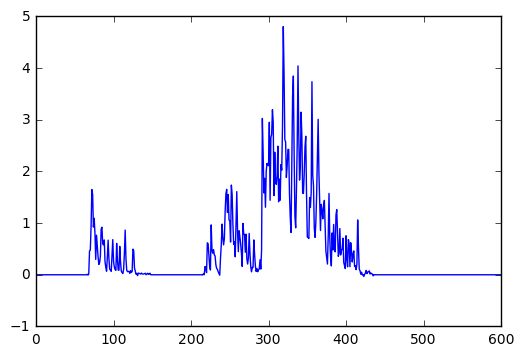

In [317]:
plt.plot(range(len(df.s2_sum_waveform.values[2])),df.s2_sum_waveform.values[2])
plt.show()

In [305]:
## Training samples without removing not working PMTs
s2_sum_waveform = df.s2_sum_waveform.values
#target = df[['z','truth_s2_n_electron']].values
target = df['z'].values
test_size = 30000
batch_size = 100
epochs = 10
remaining_size = len(s2_sum_waveform) - test_size
x_train = s2_sum_waveform[:test_size]
y_train = target[:test_size] 
x_test = s2_sum_waveform[:-test_size]
y_test = target[:-test_size] 

maxlen = len(x_train[0])
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


In [325]:
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Convolution2D

def DcNN(cnn_depth=3, # How many layers we would like for cNN and Fully connected 
         ngrids=25, # putting 601 WF channels into a 2-d space, 25 * 25 = 625 
         kernel_size = 15, # 
         keeprate=0.5, # Dropout methode for regularization
         dense_depth=2, 
         dense_channels=32,
         convolution_channels=8, # How many filters we'd like to use for cNN
         ):
    
    model = Sequential() # Sequential model from Keras
    ngrids = int(ngrids) #     
    default = {'activation' : 'elu',
              'kernel_initializer':'uniform'}

    # Input Layer
    model.add(Dense(int(ngrids*ngrids),input_shape=x_train[0].shape, **default))
    model.add(Reshape((ngrids, ngrids,1,),)) # Reshaping for cNN-2D

    for i in range(cnn_depth):
        model.add(Convolution2D(convolution_channels,
                                (int(kernel_size), int(kernel_size)), 
                                padding='same', 
                                **default))

        model.add(Dropout(keeprate)) # Drop out for 


    model.add(Flatten())
    
    for i in range(dense_depth):
        model.add(Dense(int(dense_channels), **default))
        model.add(Dropout(keeprate))

    noutput = 1 # Number of outputs, currently set as Z
    model.add(Dense(1)) # Output layer, activation depends on 
                                                                                # whether 

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

DcNN().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 625)               376250    
_________________________________________________________________
reshape_27 (Reshape)         (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 25, 25, 8)         1808      
_________________________________________________________________
dropout_196 (Dropout)        (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 25, 25, 8)         14408     
_________________________________________________________________
dropout_197 (Dropout)        (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 25, 25, 8)         14408     
__________

In [ ]:
dcnn_model = DcNN()
#dcnn_model.summary()
dcnn_model.fit(x_train, y_train, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=1) #((result - y_train)**2).sum()

Train on 27000 samples, validate on 3000 samples
Epoch 1/10
27000/27000 [==============================] - 218s 8ms/step - loss: 882.8090 - val_loss: 398.5084
Epoch 2/10
27000/27000 [==============================] - 254s 9ms/step - loss: 644.4124 - val_loss: 374.1009
Epoch 3/10
27000/27000 [==============================] - 287s 11ms/step - loss: 602.5561 - val_loss: 358.9115
Epoch 4/10
27000/27000 [==============================] - 288s 11ms/step - loss: 568.9386 - val_loss: 428.0370
Epoch 5/10
27000/27000 [==============================] - 307s 11ms/step - loss: 594.0693 - val_loss: 397.2725
Epoch 6/10
 7600/27000 [=======>......................] - ETA: 4:05 - loss: 557.9638

In [327]:
# Saving our model to Jason file for later use
model_json = dcnn_model.to_json()
with open("dcnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("dcnn_model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('dcnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("dcnn_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')

Saved model to disk


ValueError: You are trying to load a weight file containing 4 layers into a model with 8 layers.

In [321]:
y_pred_te = dcnn_model.predict(x_test)
y_pred_tr = dcnn_model.predict(x_train)

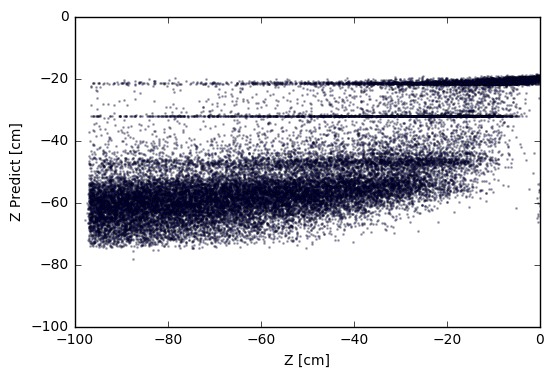

In [322]:
plt.scatter(y_train, y_pred_tr,alpha=0.3, label='Training sample',s=1)
#plt.yscale('log')
plt.xlabel('Z [cm]')
plt.ylabel('Z Predict [cm]')

plt.xlim(-100,0)
plt.ylim(-100,0)

plt.show()

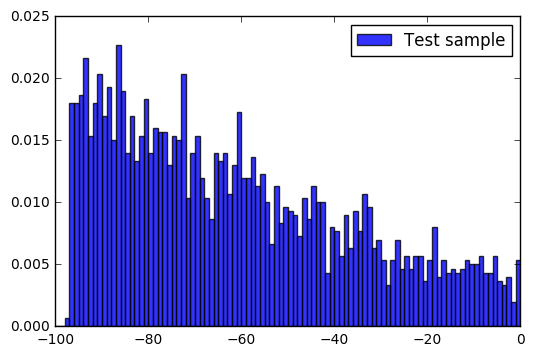

In [83]:
#plt.scatter(y_train[:,1], y_pred_tr[:,1],alpha=0.3, label='Training sample')
plt.hist(y_train,bins=100,normed=True, range=(-100,0), alpha=0.8, label='Test sample')

plt.legend()
#plt.yscale('log')
#plt.xlabel('n_e')
#plt.ylabel('n_e Predict')

#plt.xlim(-10,10)
plt.show()